In [1]:
import os
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
from tqdm import tqdm

### Json에 있는 Segmentation Annotation 추출 및 line coord 교체

In [2]:
json_dir = os.path.join("/opt/ml/data/crosswalk_filtering_poly_closed_noise_filtering.json")

with open(json_dir, "r", encoding="utf8") as outfile:
    datas = json.load(outfile)
    images = datas["images"]
    annotations = datas["annotations"]

img_df = pd.DataFrame(images)
annos_df = pd.DataFrame(annotations)

In [3]:
img_df.head()

,license,url,file_name,height,width,data_captured,id
0,0,None,MP_SEL_SUR_000033.jpg,1080,1920,None,0
1,0,None,MP_SEL_SUR_000066.jpg,1080,1920,None,1
2,0,None,MP_SEL_SUR_000084.jpg,1080,1920,None,2
3,0,None,MP_SEL_SUR_000110.jpg,1080,1920,None,3
4,0,None,MP_SEL_SUR_000119.jpg,1080,1920,None,4


In [4]:
annos_df.head()

,id,image_id,category_id,bbox,area,segmentation,iscrowd
0,0,0,1,[],0,"[[1579, 16, 1362, 19, 1351, 27, 1302, 39, 1321...",0
1,1,0,1,[],0,"[[751, 64, 434, 286, 0, 655, 4, 798, 354, 799,...",0
2,2,1,1,[],0,"[[170, 0, 1, 80, 0, 746, 424, 756, 1167, 858, ...",0
3,3,2,1,[],0,"[[1384, 603, 1088, 101, 899, 45, 765, 0, 313, ...",0
4,4,3,1,[],0,"[[1840, 463, 1370, 481, 832, 528, 478, 649, 44...",0


## line 좌표 뽑기 or polygon area 만들기

In [5]:
def draw_line(seg_data, mask_image):
    coord = []
    for seg_idx in range(0, len(seg_data), 2):
        x, y = seg_data[seg_idx], seg_data[seg_idx+1]
        coord.append([x,y])

    fill_image = cv2.fillPoly(mask_image, [np.array(coord)], 1)
    return fill_image

In [6]:

image_see = []
new_seg = {}

for idx in tqdm(range(len(set(annos_df["image_id"])))):
    seg_datas = annos_df[annos_df['image_id']==idx]["segmentation"]
    h = img_df[img_df["id"] == idx]["height"].values[0] # image h
    w = img_df[img_df["id"] == idx]["width"].values[0]
    file_name = img_df[img_df['id']==idx]['file_name'].values[0]
    file_name = file_name.split(".")[0]
    
    mask_image = np.zeros([h+1, w+1])
    for index, seg_data in seg_datas.items():
        mask_image = draw_line(seg_data[0], mask_image)

    file_dir = f"/opt/ml/data/cross_label/{file_name}.png"
    cv2.imwrite(file_dir, mask_image)
    #plt.imshow(mask_image)

100%|██████████| 1896/1896 [00:34<00:00, 55.63it/s]


## png vs jpg 검증

/opt/ml/data/cross_data/MP_SEL_SUR_001343.jpg
/opt/ml/data/cross_label/MP_SEL_SUR_001343.png


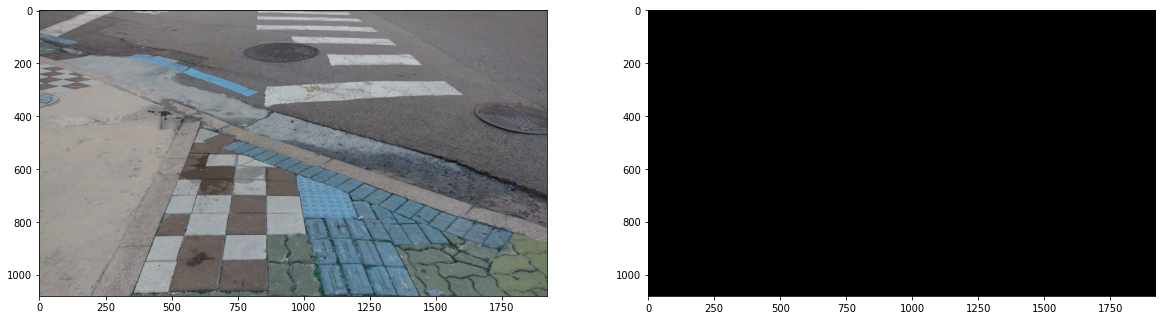

In [8]:
for idx in range(len(set(annos_df["image_id"]))):
    
    if idx == 57:
        file_name = img_df[img_df['id']==idx]['file_name'].values[0]
        file_name = file_name.split(".")[0]
    #if file_name == ""
        image_path = "/opt/ml/data/cross_data/" + file_name + ".jpg"
        label_path = "/opt/ml/data/cross_label/" + file_name + ".png"

        print(image_path)
        print(label_path)
        
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 14))
        ax[0].imshow(cv2.imread(image_path))
        ax[1].imshow(cv2.imread(label_path))
        plt.show()

        break